In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/llm-classification-finetuning/sample_submission.csv
/kaggle/input/llm-classification-finetuning/train.csv
/kaggle/input/llm-classification-finetuning/test.csv
/kaggle/input/all-minilm-l6-v2/transformers/default/1/all-MiniLM-L6-v2/rust_model.ot
/kaggle/input/all-minilm-l6-v2/transformers/default/1/all-MiniLM-L6-v2/config.json
/kaggle/input/all-minilm-l6-v2/transformers/default/1/all-MiniLM-L6-v2/README.md
/kaggle/input/all-minilm-l6-v2/transformers/default/1/all-MiniLM-L6-v2/tokenizer.json
/kaggle/input/all-minilm-l6-v2/transformers/default/1/all-MiniLM-L6-v2/tf_model.h5
/kaggle/input/all-minilm-l6-v2/transformers/default/1/all-MiniLM-L6-v2/data_config.json
/kaggle/input/all-minilm-l6-v2/transformers/default/1/all-MiniLM-L6-v2/train_script.py
/kaggle/input/all-minilm-l6-v2/transformers/default/1/all-MiniLM-L6-v2/tokenizer_config.json
/kaggle/input/all-minilm-l6-v2/transformers/default/1/all-MiniLM-L6-v2/sentence_bert_config.json
/kaggle/input/all-minilm-l6-v2/transformers/

In [2]:
import importlib
import inspect
import subprocess
import sys
from pathlib import Path

import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize as l2_normalize
import torch

SEED = 42
np.random.seed(SEED)

2025-11-06 09:14:09.280839: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762420449.467694      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762420449.531126      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Load datasets
data_dir = Path('/kaggle/input/llm-classification-finetuning/')
train_path = data_dir / 'train.csv'
test_path = data_dir / 'test.csv'
submission_path = data_dir / 'sample_submission.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
submission_template = pd.read_csv(submission_path)

target_columns = ['winner_model_a', 'winner_model_b', 'winner_tie']
label_names = {0: 'model a', 1: 'model b', 2: 'winner tie'}
train_df['winner'] = train_df[target_columns].to_numpy().argmax(axis=1)
train_df['winner_label'] = train_df['winner'].map(label_names)

print(f'Train shape: {train_df.shape}')
print(f'Test shape: {test_df.shape}')
print('Class balance:')
print(train_df['winner_label'].value_counts())
train_df.head()

Train shape: (57477, 11)
Test shape: (3, 4)
Class balance:
winner_label
model a       20064
model b       19652
winner tie    17761
Name: count, dtype: int64


,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,winner,winner_label
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0,0,model a
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0,1,model b
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1,2,winner tie
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0,0,model a
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0,1,model b


In [4]:
# Configure the pre-trained sentence embedding model
MODEL_PATH = '/kaggle/input/all-minilm-l6-v2/transformers/default/1/all-MiniLM-L6-v2'
BATCH_SIZE = 64
NORMALIZE_EMBEDDINGS = True

device = 'cuda' if torch.cuda.is_available() else 'cpu'

embedder = SentenceTransformer(MODEL_PATH, device=device)
supports_normalize = 'normalize_embeddings' in inspect.signature(embedder.encode).parameters

print(f'Using model: {MODEL_PATH}')
print(f'Embedding dimension: {embedder.get_sentence_embedding_dimension()}')
print(f'Running on device: {device}')

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Using model: /kaggle/input/all-minilm-l6-v2/transformers/default/1/all-MiniLM-L6-v2
Embedding dimension: 384
Running on device: cuda


In [6]:
def build_feature_matrix(df: pd.DataFrame, embedder: SentenceTransformer, *, batch_size: int = BATCH_SIZE, normalize: bool = NORMALIZE_EMBEDDINGS) -> np.ndarray:
    """Encode prompt, response_a, and response_b into a single feature matrix."""
    text_columns = ('prompt', 'response_a', 'response_b')
    embeddings = []
    for column in text_columns:
        sentences = df[column].astype(str).tolist()
        encode_kwargs = dict(batch_size=batch_size, convert_to_numpy=True, show_progress_bar=True)
        if normalize and supports_normalize:
            encode_kwargs['normalize_embeddings'] = True
        vectors = embedder.encode(sentences, **encode_kwargs)
        if normalize and not supports_normalize:
            vectors = l2_normalize(vectors)
        embeddings.append(vectors.astype(np.float32))
    feature_matrix = np.concatenate(embeddings, axis=1)
    return feature_matrix

In [7]:
# Encode the training set (this step can take several minutes depending on hardware)
train_features = build_feature_matrix(train_df, embedder)
train_labels = train_df['winner'].to_numpy()

print('Feature matrix shape:', train_features.shape)

Batches:   0%|          | 0/899 [00:00<?, ?it/s]

Batches:   0%|          | 0/899 [00:00<?, ?it/s]

Batches:   0%|          | 0/899 [00:00<?, ?it/s]

Feature matrix shape: (57477, 1152)


In [8]:
# Split into train/validation folds and train a classifier
X_train, X_val, y_train, y_val = train_test_split(
    train_features,
    train_labels,
    test_size=0.2,
    random_state=SEED,
    stratify=train_labels
)

classifier = LogisticRegression(
    C=1.0,
    max_iter=1000,
    solver='saga',
    multi_class='multinomial',
    n_jobs=-1,
    random_state=SEED
)
classifier.fit(X_train, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial', n_jobs=-1,
                   random_state=42, solver='saga')

In [9]:
# Evaluate on the validation split
val_predictions = classifier.predict(X_val)
val_probabilities = classifier.predict_proba(X_val)

val_accuracy = accuracy_score(y_val, val_predictions)
val_log_loss = log_loss(y_val, val_probabilities)
print(f'Validation accuracy: {val_accuracy:.4f}')
print(f'Validation log loss: {val_log_loss:.4f}')

Validation accuracy: 0.4422
Validation log loss: 1.0589


In [10]:
# Encode the test set and prepare the submission file
test_features = build_feature_matrix(test_df, embedder)
test_probabilities = classifier.predict_proba(test_features)

submission = submission_template.copy()
submission['winner_model_a'] = test_probabilities[:, 0]
submission['winner_model_b'] = test_probabilities[:, 1]
submission['winner_tie'] = test_probabilities[:, 2]

output_path = Path('/kaggle/working/submission.csv')
submission.to_csv(output_path, index=False)
print(f'Saved submission to {output_path.resolve()}')
submission.head()

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Saved submission to /kaggle/working/submission.csv


,id,winner_model_a,winner_model_b,winner_tie
0,136060,0.249839,0.315860,0.434301
1,211333,0.321036,0.270018,0.408946
2,1233961,0.317619,0.410150,0.272231


--- MiniLM 임베딩 t-SNE 시각화를 시작합니다 ---
검증 데이터 11496개 중 5000개를 무작위 추출합니다.
5000개 샘플에 대해 t-SNE(2차원 축소)를 실행합니다. (몇 분 정도 소요될 수 있습니다)
t-SNE 시각화를 생성합니다.


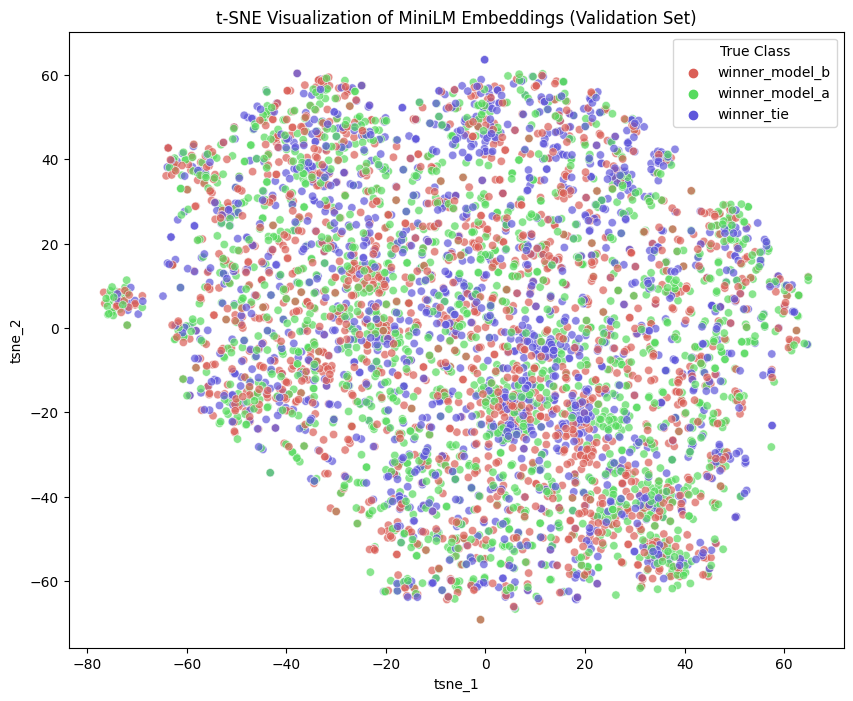

t-SNE 시각화가 'tsne_minilm.png' 파일로 저장되었습니다.


In [21]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

print("--- MiniLM 임베딩 t-SNE 시각화를 시작합니다 ---")

# --- 1. 데이터 준비 ---
# 셀 [6]에서 생성된 X_val, y_val 변수를 사용합니다.
# X_val은 이미 밀집 행렬(dense array)입니다.
try:
    X_val_dense = X_val.copy() # 원본 X_val 사용
    y_val_labels = y_val.copy() # 원본 y_val 사용
    
    # 샘플 수가 너무 많으면 t-SNE가 매우 오래 걸립니다.
    # 2000개의 샘플을 무작위로 추출합니다.
    N_SAMPLES = 5000
    if len(y_val_labels) > N_SAMPLES:
        print(f"검증 데이터 {len(y_val_labels)}개 중 {N_SAMPLES}개를 무작위 추출합니다.")
        indices = np.random.choice(X_val_dense.shape[0], N_SAMPLES, replace=False)
        X_sample = X_val_dense[indices]
        y_sample = y_val_labels[indices]
    else:
        print(f"검증 데이터 {len(y_val_labels)}개를 모두 사용합니다.")
        X_sample = X_val_dense
        y_sample = y_val_labels

except NameError as e:
    print(f"오류: {e}")
    print("이 코드를 실행하기 전에 'X_val', 'y_val' 변수가 정의되어 있는지 확인하세요.")
    raise e

# --- 2. t-SNE 실행 ---
print(f"{N_SAMPLES}개 샘플에 대해 t-SNE(2차원 축소)를 실행합니다. (몇 분 정도 소요될 수 있습니다)")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_sample)

# --- 3. 시각화 ---
# 시각화를 위해 DataFrame 생성
# 노트북 셀 [5]의 label_map에 따라: {0: 'winner_model_a', 1: 'winner_model_b', 2: 'winner_tie'}
label_to_name_map = {0: 'winner_model_a', 1: 'winner_model_b', 2: 'winner_tie'}
df_tsne = pd.DataFrame(X_tsne, columns=['tsne_1', 'tsne_2'])
df_tsne['label'] = y_sample
df_tsne['class_name'] = df_tsne['label'].map(label_to_name_map)

print("t-SNE 시각화를 생성합니다.")
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_tsne,
    x='tsne_1',
    y='tsne_2',
    hue='class_name',
    palette=sns.color_palette("hls", 3),
    alpha=0.7
)
plt.title('t-SNE Visualization of MiniLM Embeddings (Validation Set)')
plt.legend(title='True Class')
plt.savefig('tsne_minilm.png')
plt.show()

print("t-SNE 시각화가 'tsne_minilm.png' 파일로 저장되었습니다.")

In [22]:
from sklearn.metrics import silhouette_score

print("--- 실루엣 스코어(Silhouette Score)를 계산합니다 ---")

# t-SNE에 사용했던 샘플 데이터(X_sample, y_sample)를 그대로 사용합니다.
# X_sample은 t-SNE로 차원 축소하기 "전"의 원본 임베딩 샘플이어야 합니다.
try:
    # 'metric='euclidean''은 기본값이지만 명시적으로 작성
    # 샘플(2000개)이 많아도 계산에 시간이 다소 걸릴 수 있습니다.
    score = silhouette_score(X_sample, y_sample, metric='cosine')
    
    print(f"\n검증 데이터 샘플(N={len(y_sample)})에 대한 실루엣 스코어:")
    print(f"Score: {score:.4f}")
    
    print("\n[해석 가이드]")
    print("+1: 완벽 분리")
    print(" 0: 심하게 겹침 (현재 TF-IDF 상태)")
    print("-1: 오류")

except NameError as e:
    print(f"오류: {e}")
    print("'X_sample'과 'y_sample' 변수가 필요합니다. t-SNE 코드를 먼저 실행하세요.")
except Exception as e:
    print(f"계산 중 오류 발생: {e}")

--- 실루엣 스코어(Silhouette Score)를 계산합니다 ---

검증 데이터 샘플(N=5000)에 대한 실루엣 스코어:
Score: -0.0019

[해석 가이드]
+1: 완벽 분리
 0: 심하게 겹침 (현재 TF-IDF 상태)
-1: 오류
